In [1]:
'''
Created on October 31st 2017
@author: Juan Manuel Acevedo Valle
'''
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import h5py, os, sys, random
from scipy.stats import gaussian_kde
from scipy import stats
from scipy.stats.distributions import norm 

import itertools
import matplotlib
from scipy.stats import pearsonr, shapiro, anderson
from scipy.spatial import ConvexHull

colors_ = ['firebrick', 'darkgreen', 'deepskyblue', 'black', 'navy', 'grey', 'm', 'goldenrod']

from exploration.data.data import load_sim_h5_v2 as load_sim_h5
from exploration.data.PlotTools import *
from results_utils import *
from exploration.algorithm.utils.logging import read_config_log

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
for directory in ['diva_experiment_thesis_chap_5/', 'diva_experiment_thesis_chap_5_non_painful/']:
    data_files = os.listdir(directory)

    for data_file in (directory + d_f for d_f in data_files if 'sim_data.h5' in d_f):
        data_file = data_file
        conf_file = data_file.replace('sim_data.h5', 'conf.txt')
        conf = read_config_log(conf_file)
        data,foo = load_sim_h5(data_file)
        try:
            concat_sensor = np.append(concat_sensor, data.sensor.data.as_matrix(), axis=0)
        except:
            concat_sensor = data.sensor.data.as_matrix()

# print('Processing ' + group)
print("The shape of the data for PCA is:")
print(concat_sensor.shape)
pca = PCA(n_components = 4)      
pca.fit(concat_sensor[:,[0,1,3,4]])
print("Variance contribution per per principal axes: ")
print(str(pca.explained_variance_))    
print("% Variance contribution per per principal axes: ")
print( str(pca.explained_variance_ratio_))    
print("Principal directions [n_components_n_features]:")
print(pca.components_)

The shape of the data for PCA is:
(2436160, 6)
Variance contribution per per principal axes: 
[0.64314066 0.47598751 0.01136132 0.01066491]
% Variance contribution per per principal axes: 
[0.56358777 0.41711053 0.00995599 0.00934572]
Principal directions [n_components_n_features]:
[[ 0.51247891  0.61109407  0.39754124  0.45375143]
 [-0.37522677 -0.4725009   0.51736212  0.60686425]
 [-0.61403349  0.50993004 -0.44976753  0.40080344]
 [ 0.46854361 -0.3785212  -0.60992341  0.51495828]]


In [3]:
import h5py, random
from scipy.stats import gaussian_kde
from scipy.stats.distributions import norm    

def getPDFx_y(data):
    x_grid = np.linspace(-2.0, 2., 500)
    y_grid = np.linspace(-2.0, 2., 500)
    
    sensor_data = pca.transform(data)
    
    kde_x = gaussian_kde(sensor_data[:,0])
    pdf_x = kde_x.evaluate(x_grid)

    kde_y = gaussian_kde(sensor_data[:,1])
    pdf_y = kde_y.evaluate(y_grid)
               
    tmp_dict = {'KDEx_': kde_x, 'KDEy_': kde_y, 'PDFx_': pdf_x, 'PDFy_': pdf_y, 'x_grid': x_grid, 'y_grid': y_grid}
    return tmp_dict

In [4]:
n_samples = 101000
mode_ops = ['autonomous','autonomous_pain']
type_ops = ['proprio','simple']

groups = itertools.product(mode_ops, type_ops)

dist_used = 'euclidean'
sensor_data = None

legends = []
pdf_data = []
for i,directory in enumerate(['diva_experiment_thesis_chap_5/', 'diva_experiment_thesis_chap_5_non_painful/']):
    data_files = [directory + file_ for file_ in os.listdir(directory)]
    for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
        conf_file = data_file.replace('sim_data.h5', 'conf.txt')
        conf = read_config_log(conf_file)

        data,foo = load_sim_h5(data_file)
        if conf['type']=='simple':
            try:
                concat_sensor_s = np.append(concat_sensor_s, data.sensor.data.as_matrix()[\
                                                np.where(data.cons.data.as_matrix()==0.)[0],:], axis=0)
            except:
                concat_sensor_s = data.sensor.data.as_matrix()[\
                                                np.where(data.cons.data.as_matrix()==0.)[0],:]
        elif conf['type']=='proprio':
            try:
                concat_sensor_p = np.append(concat_sensor_p, data.sensor.data.as_matrix()[\
                                                np.where(data.cons.data.as_matrix()==0.)[0],:], axis=0)
            except:
                concat_sensor_p = data.sensor.data.as_matrix()[\
                                                np.where(data.cons.data.as_matrix()==0.)[0],:]
    pdf_data += [getPDFx_y(concat_sensor_s[:,[0,1,3,4]])]
    pdf_data += [getPDFx_y(concat_sensor_p[:,[0,1,3,4]])]
    if 'pain' in directory:
        legends += ['simple (No pain during initialization)']
        legends += ['somesthetic (No pain during initialization)']
    else:
        legends += ['simple','somesthetic']
    del concat_sensor_s
    del concat_sensor_p

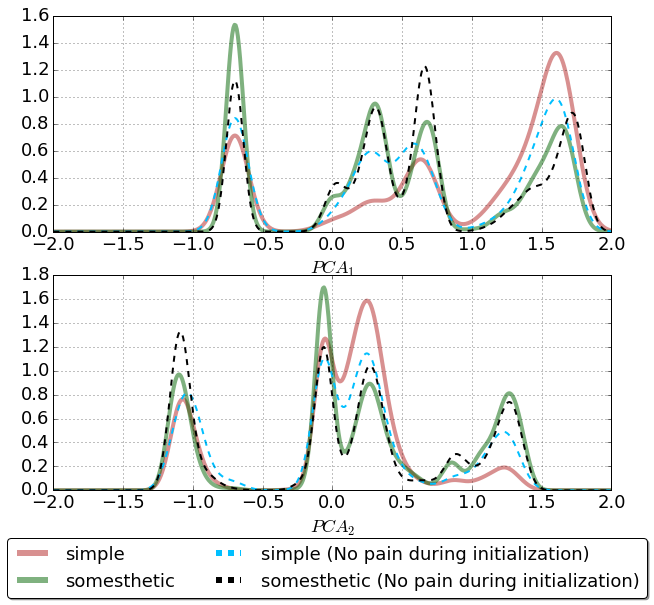

In [10]:
def plotPDFx_y(axes, pdf_data, color, ls='-', lw=3.5, alpha=0.4):
    x_grid = pdf_data['x_grid']
    y_grid = pdf_data['y_grid']
    
    pdf_x = pdf_data['PDFx_']
    pdf_y = pdf_data['PDFy_']

    axes[0].plot(x_grid, pdf_x, color=color, alpha=alpha, lw=lw, ls=ls)
    axes[0].set_xlim(-2, 2)

    axes[1].plot(y_grid, pdf_y, color=color, alpha=alpha, lw=lw, ls=ls)
    axes[1].set_xlim(-2, 2)

matplotlib.rcParams['figure.figsize'] = (10.0, 8.5)
matplotlib.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(2,1)
lgd_ = []
ls_ = ['-','-','--','--']
lw = [4,4,2,2]
a = [0.5,0.5,1,1]
for i, (pdf,lgd_k) in enumerate(zip(pdf_data,legends)):
    plotPDFx_y(axes, pdf, colors_[i], ls=ls_[i], lw=lw[i], alpha=a[i])
    lgd_ += lgd_k
plt.sca(axes[0])
plt.xlabel('$PCA_1$')
plt.sca(axes[1])
plt.xlabel('$PCA_2$')

lgd = plt.legend(legends,ncol=2,loc='lower right', fontsize=18, bbox_to_anchor=(1.08, -0.54),
          fancybox=True, shadow=True)
for legobj in lgd.legendHandles:
    legobj.set_linewidth(6.0)
for ax in axes:
    plt.sca(ax)
    plt.grid(True)

In [11]:
fig.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter5/images/PCA_no_pain.eps',\
               format='eps', dpi=1000,bbox_extra_artists=(lgd,), bbox_inches='tight')

In [7]:
np.where(data.cons.data.as_matrix()==0.)[0]

array([   128,    155,    372, ..., 101007, 101008, 101009])